In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_parquet('sm_data_opt.parquet')

### Users metrics  
- Количество уникальных пользователей (total_users)
- Количество авторизованных пользователей (authorized_users)
- Количество пользователей, добавивших товар в корзину (users_cart)
- Количество пользователей, оформивших заказ (users_order)
- Количество пользователей, оформивших заказ более 2 раз (repeat_users)

In [4]:
total_users = df['user_id'].nunique()
authorized_users = df.loc[df['user_is_authorized'] == True, 'user_id'].nunique()
users_cart = df.loc[df['add_to_cart_flag'] == True, 'user_id'].nunique()
users_order = df.loc[df['create_order_flag'] == True, 'user_id'].nunique()
user_orders = df[df['create_order_flag']].groupby('user_id').size()
repeat_users = (user_orders > 1).sum()

In [5]:
user_metrics = pd.DataFrame({
    "metric": [
        "total_users",
        "authorized_users",
        "users_added_to_cart",
        "users_with_order",
        "repeat_orders_users"
    ],
    "value": [
        total_users,
        authorized_users,
        users_cart,
        users_order,
        repeat_users
    ]
})
user_metrics

,metric,value
0,total_users,2108035
1,authorized_users,1561224
2,users_added_to_cart,628469
3,users_with_order,207169
4,repeat_orders_users,74608


- Количество пользователей по устройствам (device_counts)
- Количество пользователей, которые использовали несколько устройств (multi_device_users)

In [7]:
users_by_device = df.groupby('device_type', observed=True)['user_id'].nunique()
device_counts = df.groupby('user_id', observed=True)['device_type'].nunique()
multi_device_users = (device_counts >= 2).sum()
multi_device_user_ids = device_counts[device_counts >= 2].index

In [8]:
desktop_users = df[df['device_type'] == 'desktop']['user_id'].nunique()
android_users = df[df['device_type'] == 'mobileapp_android']['user_id'].nunique()
ios_users = df[df['device_type'] == 'mobileapp_ios']['user_id'].nunique()

desktop_auth = df[(df['device_type'] == 'desktop') & (df['user_is_authorized'] == True)]['user_id'].nunique()
android_auth = df[(df['device_type'] == 'mobileapp_android') & (df['user_is_authorized'] == True)]['user_id'].nunique()
ios_auth = df[(df['device_type'] == 'mobileapp_ios') & (df['user_is_authorized'] == True)]['user_id'].nunique()

desktop_cart = df[(df['device_type'] == 'desktop') & (df['add_to_cart_flag'] == True)]['user_id'].nunique()
android_cart = df[(df['device_type'] == 'mobileapp_android') & (df['add_to_cart_flag'] == True)]['user_id'].nunique()
ios_cart = df[(df['device_type'] == 'mobileapp_ios') & (df['add_to_cart_flag'] == True)]['user_id'].nunique()

desktop_order = df[(df['device_type'] == 'desktop') & (df['create_order_flag'] == True)]['user_id'].nunique()
android_order = df[(df['device_type'] == 'mobileapp_android') & (df['create_order_flag'] == True)]['user_id'].nunique()
ios_order = df[(df['device_type'] == 'mobileapp_ios') & (df['create_order_flag'] == True)]['user_id'].nunique()

multi_auth = df[(df['user_is_authorized'] == True) & (df['user_id'].isin(multi_device_user_ids))]['user_id'].nunique()
multi_cart = df[(df['add_to_cart_flag'] == True) & (df['user_id'].isin(multi_device_user_ids))]['user_id'].nunique()
multi_order = df[(df['create_order_flag'] == True) & (df['user_id'].isin(multi_device_user_ids))]['user_id'].nunique()

In [9]:
device = pd.DataFrame({
    'device_type': ['desktop', 'mobileapp_android', 'mobileapp_ios', 'multi_device', 'total'],
    'unique_users': [desktop_users, android_users, ios_users, multi_device_users, 0],
    'authorized_users': [desktop_auth, android_auth, ios_auth, multi_auth, authorized_users],
    'users_with_cart': [desktop_cart, android_cart, ios_cart, multi_cart, users_cart],
    'users_with_order': [desktop_order, android_order, ios_order, multi_order, users_order]   
}).set_index('device_type')

device.loc['total', 'unique_users'] = desktop_users + android_users + ios_users - multi_device_users

device

,unique_users,authorized_users,users_with_cart,users_with_order
device_type,,,,
desktop,513053,122967,68424,15690
mobileapp_android,988227,901637,343871,118595
mobileapp_ios,649363,577975,227773,76139
multi_device,42290,42273,29534,14794
total,2108353,1561224,628469,207169


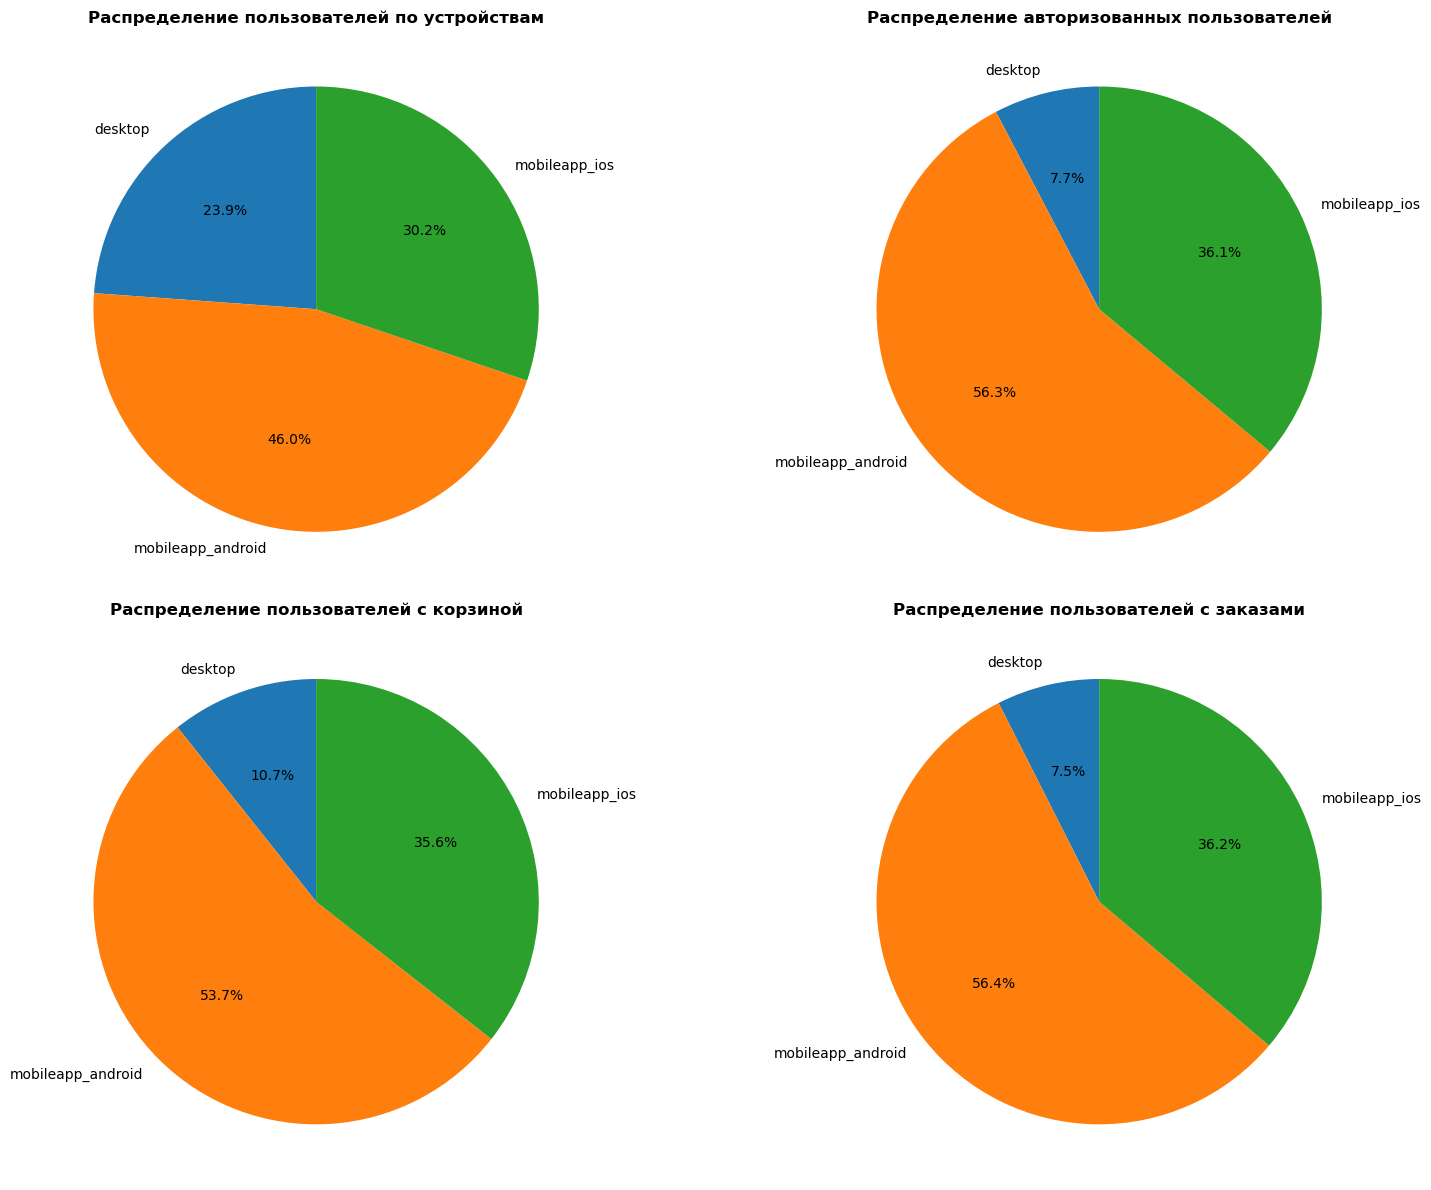

In [10]:
# Круговые диаграммы для распределения по устройствам
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plot_data = device.drop(['total', 'multi_device'])

plot_data['unique_users'].plot(kind='pie', ax=axes[0,0], autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Распределение пользователей по устройствам', fontweight='bold')
axes[0,0].set_ylabel('')

plot_data['authorized_users'].plot(kind='pie', ax=axes[0,1], autopct='%1.1f%%', startangle=90)
axes[0,1].set_title('Распределение авторизованных пользователей', fontweight='bold')
axes[0,1].set_ylabel('')

plot_data['users_with_cart'].plot(kind='pie', ax=axes[1,0], autopct='%1.1f%%', startangle=90)
axes[1,0].set_title('Распределение пользователей с корзиной', fontweight='bold')
axes[1,0].set_ylabel('')

plot_data['users_with_order'].plot(kind='pie', ax=axes[1,1], autopct='%1.1f%%', startangle=90)
axes[1,1].set_title('Распределение пользователей с заказами', fontweight='bold')
axes[1,1].set_ylabel('')

plt.tight_layout()
plt.show()

### Расчет конверсий
1. Конверсия авторизации (auth_conversion) *авторизованные пользователи/все пользователи*
2. Конверсия в корзину (cart_conversion) *пользователи с корзиной/все пользователи*
3. Конверсия в заказ (order_conversion) *оформившие заказ/пользователи с корзиной*
4. Общая конверсия (all_conversion) *из всех пользователей в заказы*
5. Retention rate (retention_rate) *пользователи с повторными заказами/все пользователи*

In [12]:
conversion = {
    'auth_conversion': round(authorized_users / total_users * 100, 2),
    'cart_conversion': round(users_cart / total_users * 100, 2),
    'order_conversion': round(users_order / users_cart * 100, 2),
    'all_conversion': round(users_order / total_users * 100, 2),
    'retention_rate': round(repeat_users / total_users * 100, 2)
}

conversion = pd.DataFrame([conversion])
conversion = conversion.T
conversion.columns = ['value']
print(conversion)

                  value
auth_conversion   74.06
cart_conversion   29.81
order_conversion  32.96
all_conversion     9.83
retention_rate     3.54


### Активность пользователей

In [14]:
# активность пользователей по времени суток (с 6 утра до 12 дня, с 12 до 18, с 18 до 00 и с 00 до 6 утра)
morning_users = df.loc[df['create_timestamp'].dt.hour.between(6, 11)].shape[0]
day_users = df.loc[df['create_timestamp'].dt.hour.between(12, 17)].shape[0]
night_users = df.loc[(df['create_timestamp'].dt.hour.between(18, 23) | df['create_timestamp'].dt.hour.between(0, 5))].shape[0]

# добавления в корзину
morning_carts = df.loc[(df['add_to_cart_flag'] == True) & (df['create_timestamp'].dt.hour.between(6, 11))].shape[0]
day_carts = df.loc[(df['add_to_cart_flag'] == True) & (df['create_timestamp'].dt.hour.between(12, 17))].shape[0]
night_carts = df.loc[(df['add_to_cart_flag'] == True) & (df['create_timestamp'].dt.hour.between(18, 23) | df['create_timestamp'].dt.hour.between(0, 5))].shape[0]

# оформление заказов
morning_orders = df.loc[(df['create_order_flag'] == True) & (df['create_timestamp'].dt.hour.between(6, 11))].shape[0]
day_orders = df.loc[(df['create_order_flag'] == True) & (df['create_timestamp'].dt.hour.between(12, 17))].shape[0]
night_orders = df.loc[(df['create_order_flag'] == True) & (df['create_timestamp'].dt.hour.between(18, 23) | df['create_timestamp'].dt.hour.between(0, 5))].shape[0]

time_activity = pd.DataFrame({
    'time_of_day': ['morning', 'day', 'night'],
    'total_active_users': [morning_users, day_users, night_users],
    'total_carts': [morning_carts, day_carts, night_carts],
    'total_orders': [morning_orders, day_orders, night_orders]
}).set_index('time_of_day')

time_activity.loc['total'] = time_activity.sum()

print(time_activity)

             total_active_users  total_carts  total_orders
time_of_day                                               
morning                 1858122       342923         90769
day                     2361850       471837        135191
night                   2780028       500753        124343
total                   7000000      1315513        350303


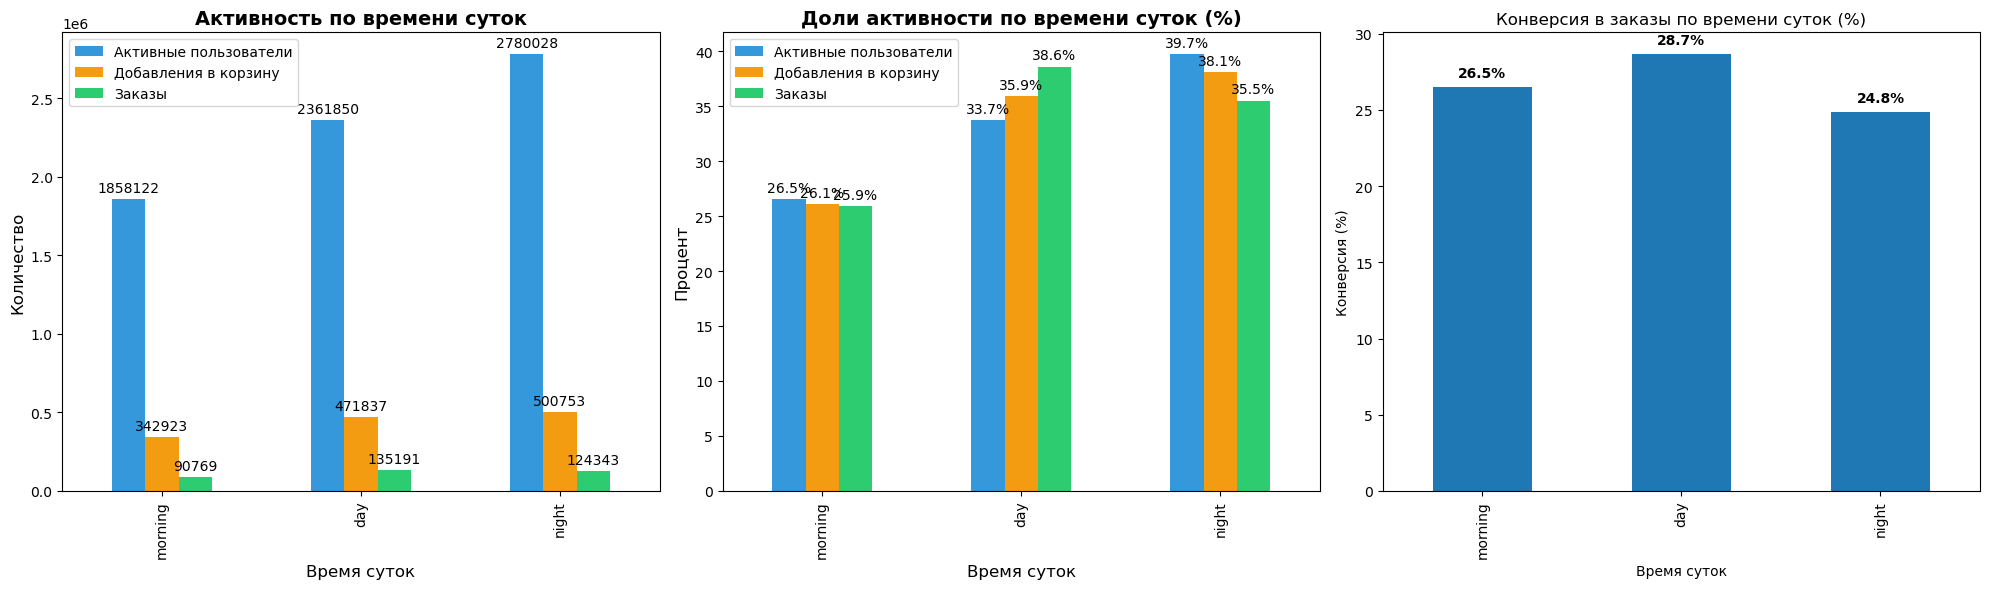

In [43]:
time_activity_viz = time_activity.drop('total')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Абсолютные значения
time_activity_viz[['total_active_users', 'total_carts', 'total_orders']].plot(
    kind='bar', ax=ax1, color=['#3498db', '#f39c12', '#2ecc71']
)
ax1.set_title('Активность по времени суток', fontsize=14, fontweight='bold')
ax1.set_ylabel('Количество', fontsize=12)
ax1.set_xlabel('Время суток', fontsize=12)
ax1.legend(['Активные пользователи', 'Добавления в корзину', 'Заказы'])

for container in ax1.containers:
    ax1.bar_label(container, fmt='%.0f', padding=3)

# Доли от общего числа
time_pct = (time_activity_viz / time_activity_viz.sum()) * 100
time_pct[['total_active_users', 'total_carts', 'total_orders']].plot(
    kind='bar', ax=ax2, color=['#3498db', '#f39c12', '#2ecc71']
)
ax2.set_title('Доли активности по времени суток (%)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Процент', fontsize=12)
ax2.set_xlabel('Время суток', fontsize=12)
ax2.legend(['Активные пользователи', 'Добавления в корзину', 'Заказы'])

for container in ax2.containers:
    ax2.bar_label(container, fmt='%.1f%%', padding=3)

# Конверсии
conversion_rates = (time_activity_viz['total_orders'] / time_activity_viz['total_carts'] * 100)
conversion_rates.plot(kind='bar', ax=ax3)
ax3.set_title('Конверсия в заказы по времени суток (%)')
ax3.set_ylabel('Конверсия (%)')
ax3.set_xlabel('Время суток')

for i, v in enumerate(conversion_rates):
    ax3.text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [15]:
# активность пользователей по дням недели
dow_activity = pd.DataFrame({
    'total_active_users': df.groupby(df['create_timestamp'].dt.day_name()).size(),
    'cart_activity': df[df['add_to_cart_flag']].groupby(df['create_timestamp'].dt.day_name()).size(),
    'order_activity': df[df['create_order_flag']].groupby(df['create_timestamp'].dt.day_name()).size()
})

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_activity = dow_activity.reindex(day_order)

dow_activity.loc['total'] = dow_activity.sum()

print(dow_activity)

                  total_active_users  cart_activity  order_activity
create_timestamp                                                   
Monday                       1099696         214194           61039
Tuesday                      1003870         179501           44071
Wednesday                    1004217         182439           45946
Thursday                      950544         171863           42906
Friday                        678715         126576           32048
Saturday                     1061164         203513           55344
Sunday                       1201794         237427           68949
total                        7000000        1315513          350303


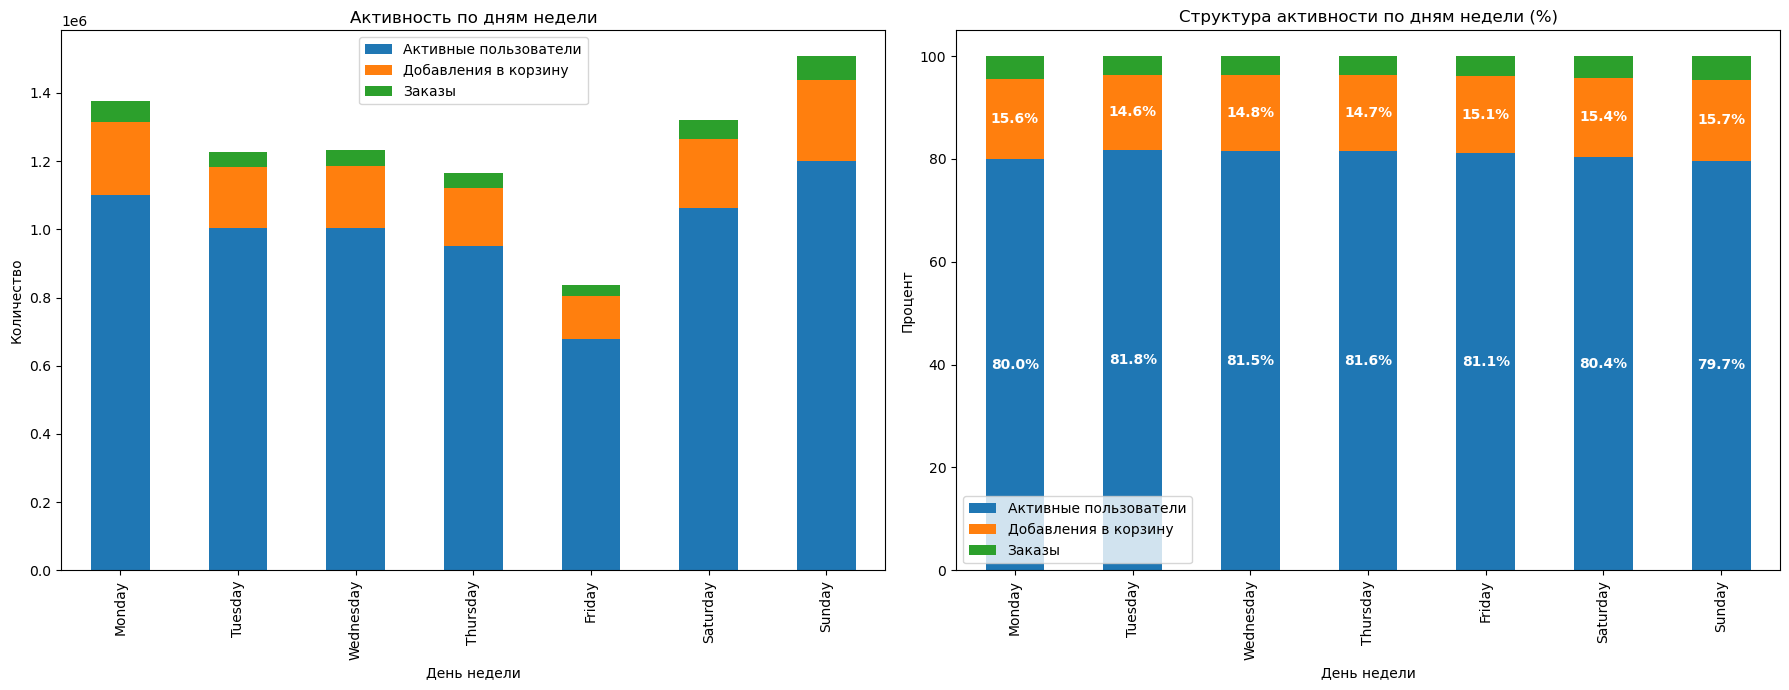

In [45]:
dow_activity_viz = dow_activity.drop('total')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Абсолютные значения
dow_activity_viz[['total_active_users', 'cart_activity', 'order_activity']].plot(kind='bar', stacked=True, ax=ax1)
ax1.set_title('Активность по дням недели')
ax1.set_ylabel('Количество')
ax1.set_xlabel('День недели')
ax1.legend(['Активные пользователи', 'Добавления в корзину', 'Заказы'])

# Доли
dow_pct = dow_activity_viz.div(dow_activity_viz.sum(axis=1), axis=0) * 100
dow_pct[['total_active_users', 'cart_activity', 'order_activity']].plot(kind='bar', stacked=True, ax=ax2)
ax2.set_title('Структура активности по дням недели (%)')
ax2.set_ylabel('Процент')
ax2.set_xlabel('День недели')
ax2.legend(['Активные пользователи', 'Добавления в корзину', 'Заказы'])

for i, (idx, row) in enumerate(dow_pct.iterrows()):
    cumulative = 0
    for col, value in row.items():
        if value > 5:
            ax2.text(i, cumulative + value/2, f'{value:.1f}%', 
                    ha='center', va='center', fontweight='bold', color='white')
        cumulative += value

plt.tight_layout()
plt.show()

In [16]:
total_events = len(df)
cart_event = df['add_to_cart_flag'].sum()
order_event = df['create_order_flag'].sum()

print('Всего событий', total_events)
print('Количество добавлений в корзину', cart_event)
print('Количество оформлений заказов', order_event)

Всего событий 7000000
Количество добавлений в корзину 1315513
Количество оформлений заказов 350303


### Анализ по регионам

In [51]:
regional_metrics = df.groupby('location_id').agg({
    'user_id': 'nunique', 
    'event_id': 'count', 
    'product_is_pick_up': 'sum', 
    'product_is_pick_point': 'sum', 
    'product_is_delivery': 'sum', 
    'product_is_now': 'sum'
}).reset_index()

regional_metrics.columns = [
    'location_id', 
    'users_count', 
    'product_view_count', 
    'total_pick_up_available',
    'total_pick_point_available', 
    'total_delivery_available',
    'total_now_available'
]
regional_metrics

,location_id,users_count,product_view_count,total_pick_up_available,total_pick_point_available,total_delivery_available,total_now_available
0,1,1,1,1,1,0,1
1,2,1,4,2,4,4,2
2,3,26,70,51,0,0,35
3,4,73,183,139,135,0,89
4,5,4,4,2,4,0,0
...,...,...,...,...,...,...,...
4696,4697,1,2,2,0,2,2
4697,4698,1,2,0,0,2,0
4698,4699,1,3,3,3,3,3
4699,4700,1,2,2,1,0,2
